In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
num_classes = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset"
)

Found 2152 files belonging to 3 classes.


In [4]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [5]:
class_names = dataset.class_names
class_names

['Early blight', 'Healthy', 'Late blight']

In [6]:
train_ds , val_ds, test_ds = get_dataset_partitions(dataset)

In [7]:
len(train_ds)

54

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
r = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 37s 361ms/step - loss: 0.6747 - accuracy: 0.7135 - val_loss: 0.4488 - val_accuracy: 0.8490
Epoch 2/10
54/54 [==============================] - 13s 246ms/step - loss: 0.3713 - accuracy: 0.8600 - val_loss: 0.3377 - val_accuracy: 0.9010
Epoch 3/10
54/54 [==============================] - 12s 231ms/step - loss: 0.3730 - accuracy: 0.8449 - val_loss: 0.3938 - val_accuracy: 0.8646
Epoch 4/10
54/54 [==============================] - 12s 230ms/step - loss: 0.3072 - accuracy: 0.8733 - val_loss: 0.2203 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 12s 223ms/step - loss: 0.2154 - accuracy: 0.9190 - val_loss: 0.1604 - val_accuracy: 0.9635
Epoch 6/10
54/54 [==============================] - 12s 221ms/step - loss: 0.1569 - accuracy: 0.9358 - val_loss: 0.1801 - val_accuracy: 0.9375
Epoch 7/10
54/54 [==============================] - 12s 220ms/step - loss: 0.1569 - accuracy: 0.9433 - val_loss: 0.1947 - val_accuracy: 0.9167

In [15]:
scores = model.evaluate(test_ds)
print(f"Loss : {scores[0]*100},\nAccuracy : {scores[1]*100}")

8/8 [==============================] - 2s 37ms/step - loss: 0.1703 - accuracy: 0.9336
Loss : 17.028149962425232,
Accuracy : 93.359375


In [16]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Taining and Validation loss')

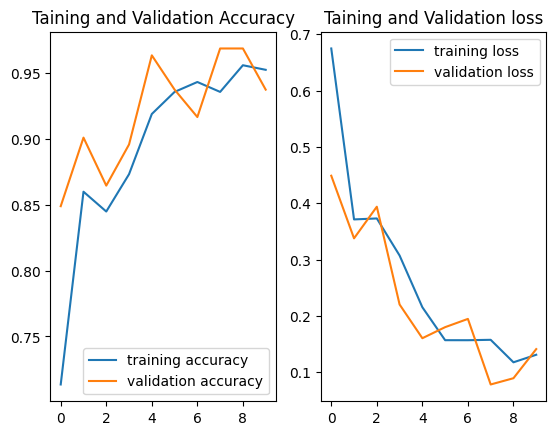

In [23]:
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),r.history["accuracy"], label="training accuracy")
plt.plot(range(EPOCHS),r.history["val_accuracy"], label="validation accuracy")
plt.legend(loc="lower right")
plt.title("Taining and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),r.history["loss"], label="training loss")
plt.plot(range(EPOCHS),r.history["val_loss"], label="validation loss")
plt.legend(loc="upper right")
plt.title("Taining and Validation loss")

In [24]:
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])) , 2)
    return predicted_class , confidence

1/1 [==============================] - 0s 31ms/step


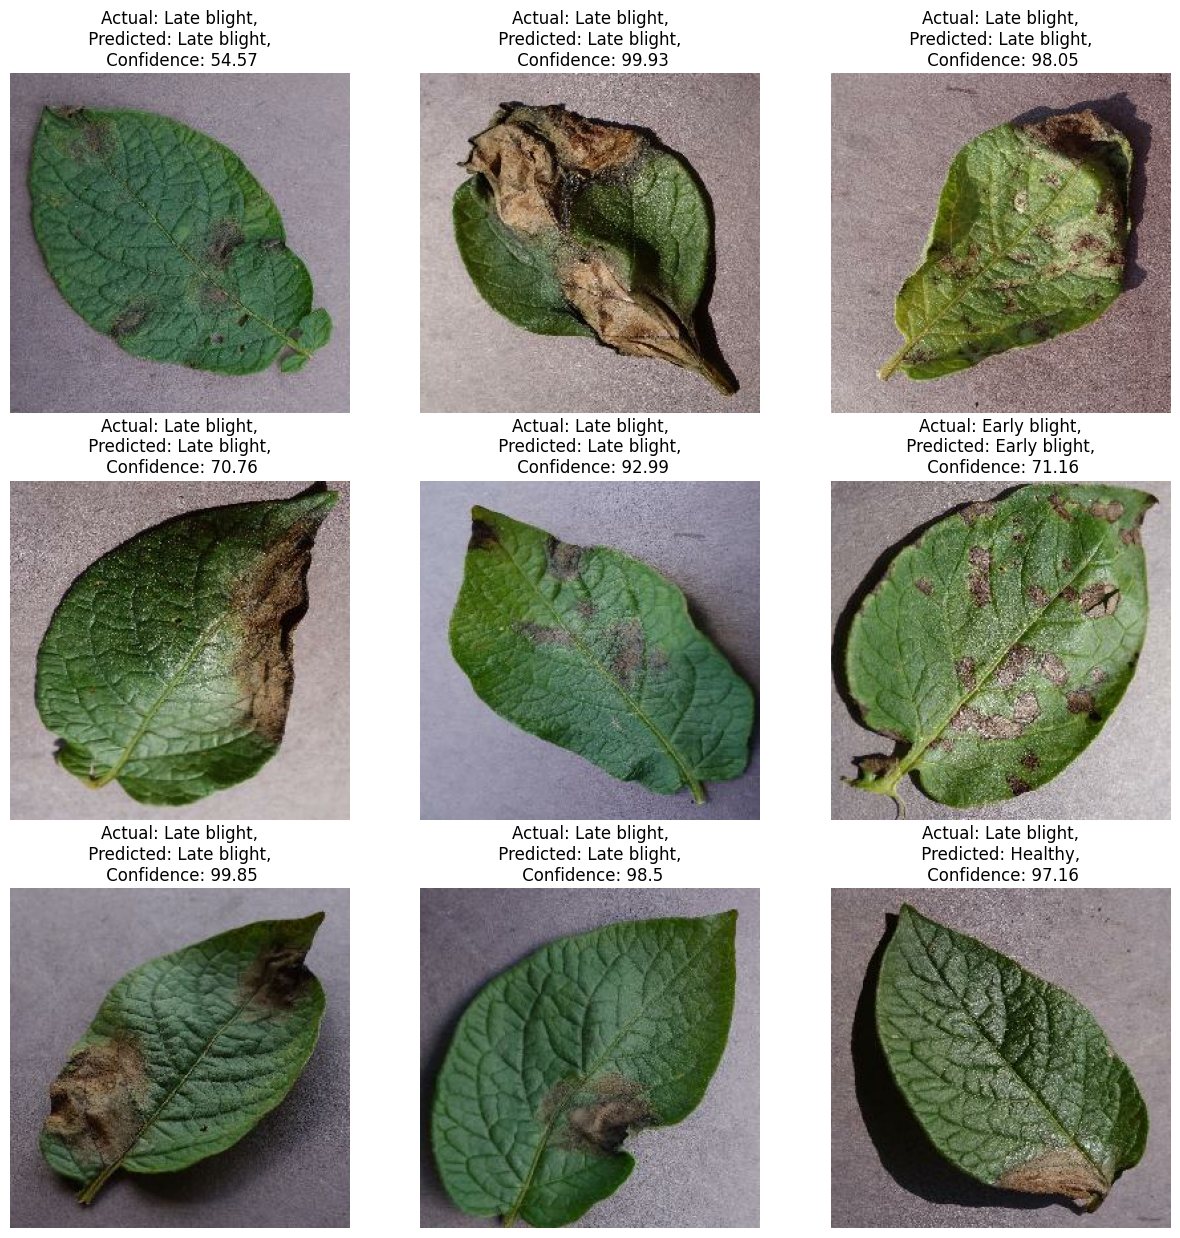

In [33]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}")

In [34]:
from tensorflow.keras.models import load_model
model.save("../Saved_models/model_trained.h5")